In [1]:
import matplotlib.pyplot as plt, mpld3
import re
from dateutil.parser import parse
from matplotlib.patches import ConnectionPatch
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
with open("C:/Users/Michael/Documents/Jobs/applied_8_9_2022.txt", "r", encoding="utf-8") as file:
    text = file.readlines()

In [3]:
# filter job lines
date_dict = {}

for line in text:
    try: 
        date = parse(line)
        date_dict[date] = []
    except:
        if ":" in line:
            date_dict[date].append(line)

jobs_by_date = [item for sublist in [list(map(lambda vv: (k, vv), v)) for k, v in date_dict.items()] for item in sublist]

In [4]:
df = pd.DataFrame(jobs_by_date, columns=["Date_Applied", "Line"])

In [39]:
df["Company"] = df["Line"].str.strip().str.split(":|-|==>").apply(lambda l: l[0].strip())
df["Title"] = df["Line"].str.strip().str.split(":|-|==>").apply(lambda l: l[1].strip().title())
df["Result"] = df["Line"].str.strip().str.split("==>").apply(lambda l: l[1].strip().title() if len(l) > 1 else "No Response")
df["DOW"] = df["Date_Applied"].apply(lambda d: d.day_name())

In [40]:
# rejection PB is 37 minutes
df["Result"].value_counts(dropna=False)

No Response        124
Rejected            51
Contacted            3
First Interview      3
Scam                 2
Third Interview      1
Name: Result, dtype: int64

In [41]:
# industry of company
df

,Date_Applied,Line,Company,Title,Result,DOW
0,2022-08-09,NYT: Data Insights (Games)- wordleBitch123$\n,NYT,Data Insights (Games),No Response,Tuesday
1,2022-08-09,"SPOTIFY: Data Scientist, Spotify for Artists =...",SPOTIFY,"Data Scientist, Spotify For Artists",Rejected,Tuesday
2,2022-08-09,DOW JONES: Data Analyst - wordleBitch123$\n,DOW JONES,Data Analyst,No Response,Tuesday
3,2022-08-09,MANTECH: Data Science/Analytics New Graduate -...,MANTECH,Data Science/Analytics New Graduate,No Response,Tuesday
4,2022-08-09,OSCAR HEALTH: Data Scientist\n,OSCAR HEALTH,Data Scientist,No Response,Tuesday
...,...,...,...,...,...,...
179,2022-11-04,TVISION: Data Scientist\n,TVISION,Data Scientist,No Response,Friday
180,2022-11-04,ENEBA: Data Analyst\n,ENEBA,Data Analyst,No Response,Friday
181,2022-11-04,MOUNT SINAI: Data Science Analyst - Genetics R...,MOUNT SINAI,Data Science Analyst,No Response,Friday
182,2022-11-04,RESILIENCE: Data Analyst\n,RESILIENCE,Data Analyst,No Response,Friday


In [58]:
df["DOW"].value_counts()

Tuesday      45
Wednesday    43
Friday       28
Thursday     22
Monday       20
Sunday       13
Saturday     13
Name: DOW, dtype: int64

In [67]:
DOW_dict = {"Monday": 0,
           "Tuesday": 1,
           "Wednesday": 2,
           "Thursday": 3,
           "Friday": 4,
           "Saturday": 5,
           "Sunday": 6}

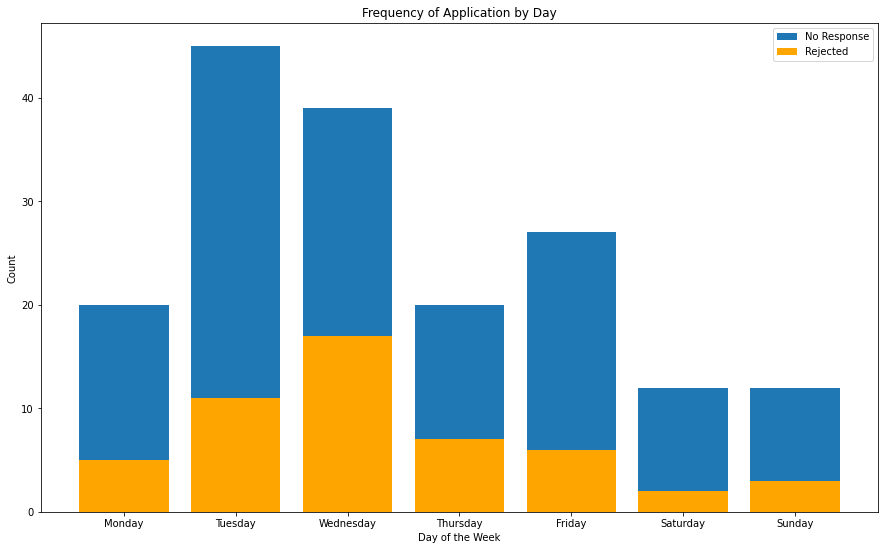

In [118]:
dow_apps = df[(df["Result"] == "No Response") | (df["Result"] == "Rejected")].groupby("DOW").count()["Result"].sort_index(key=lambda d: d.map(DOW_dict))
dow_rej = df[df["Result"] == "Rejected"].groupby("DOW").count()["Result"].sort_index(key=lambda d: d.map(DOW_dict))

fig, ax = plt.subplots(1,1, figsize=(15,9))

ax.bar(x=dow_apps.index, height=dow_apps, label="No Response")
ax.bar(x=dow_rej.index, height=dow_rej, color="Orange", label="Rejected")

ax.set_ylabel("Count")
ax.set_xlabel("Day of the Week")
ax.set_title("Frequency of Application by Day")
ax.legend()

Text(0.5, 0, 'Date')

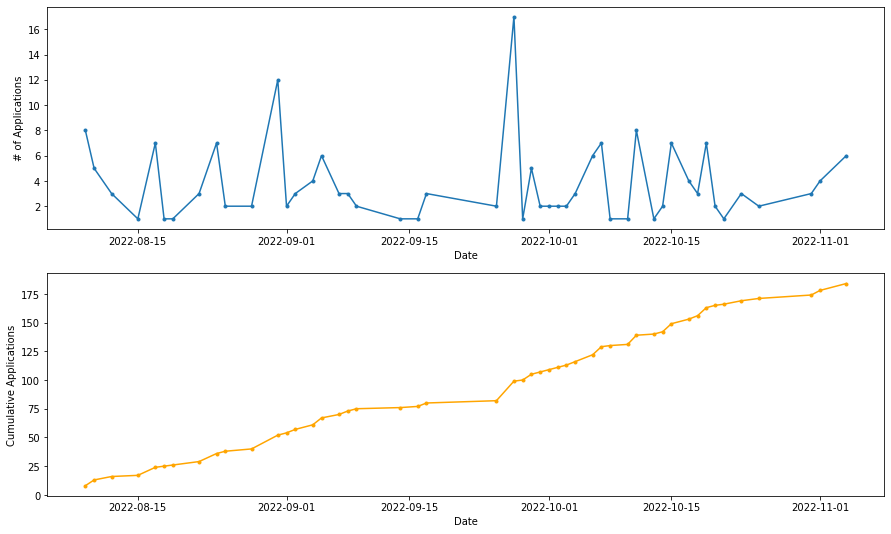

In [25]:
fig, ax = plt.subplots(2,1, figsize=(15,9))

resume_dates = ["2022-08-12", "2022-08-19", "2022-08-31", "2022-09-05"]
interview_dates = ["2022-09-07", "2022-10-06", "2022-10-15", "2022-10-19"]

ax[0].plot(df.groupby("Date_Applied").count()["Line"], marker=".")
ax[1].plot(df.groupby("Date_Applied").count()["Line"].cumsum(), c="orange", marker=".")

ax[0].set_ylabel("# of Applications")
ax[1].set_ylabel("Cumulative Applications")

ax[0].set_xlabel("Date")
ax[1].set_xlabel("Date")

#mpld3.show()

0      Tuesday
1      Tuesday
2      Tuesday
3      Tuesday
4      Tuesday
        ...   
179     Friday
180     Friday
181     Friday
182     Friday
183     Friday
Name: Date_Applied, Length: 184, dtype: object

Text(0.5, 1.0, 'Results of Responses')

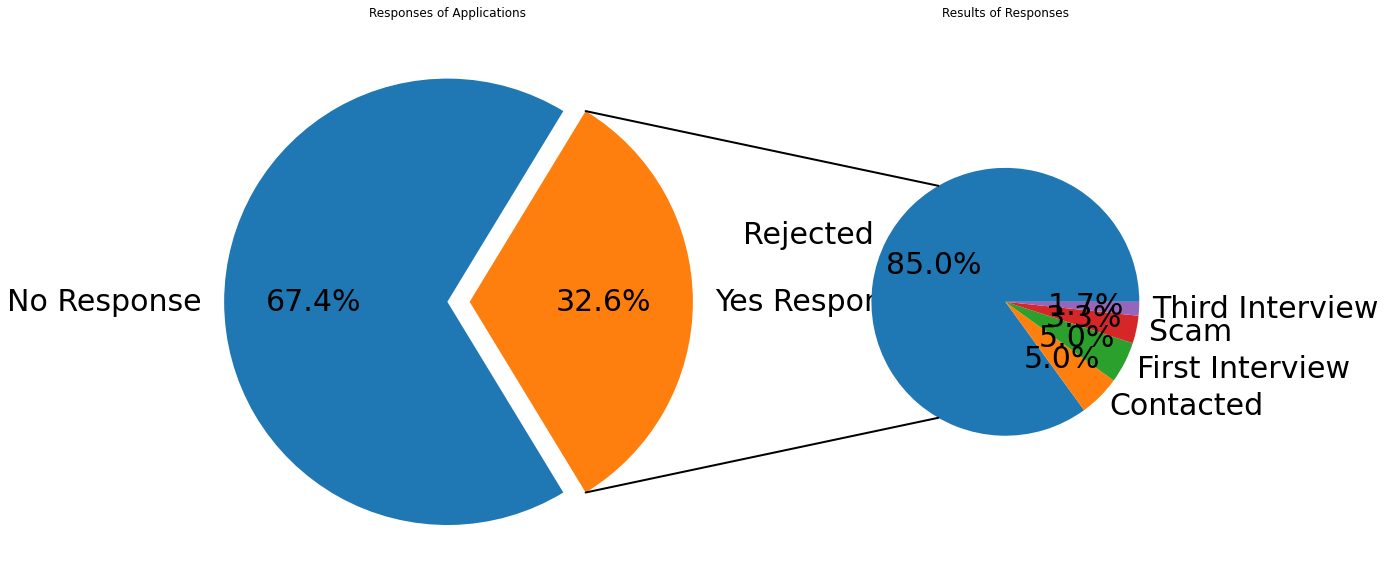

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,15))
fig.subplots_adjust(wspace=0)

woi = "Yes Response"
explosion_size = 0.1

color_map = {"Rejected": "Red",
            "Scam": "Orange",
            "Contacted": "Yellow"}

response_binary = df["Result"].where(df["Result"] == "No Response", "Yes Response")

pie_data = response_binary
subpie_data = df["Result"][df["Result"] != "No Response"]

## setting up pie chart

# ratios
ratios = pie_data.value_counts() / len(pie_data)

# labels
labels = pie_data.value_counts().index

# get explosions and angle for wedge of interest
explode = [explosion_size if label == woi else 0.0 for label in labels]
angle = 180 * ratios[woi]

# plot pie
wedges, *_ = ax1.pie(pie_data.value_counts(), autopct="%1.1f%%", labels=pie_data.value_counts().index, explode=explode, startangle=angle, textprops={'fontsize': 30})

## setting up sub-pie chart

# ratios
ratios = subpie_data.value_counts() / len(subpie_data)

# labels and sizes
labels = subpie_data.value_counts().index

# plot subpie
subwedges, *_ = ax2.pie(subpie_data.value_counts(), autopct="%1.1f%%", labels=subpie_data.value_counts().index, radius=0.6, textprops={'fontsize': 30})

## connecting
# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[1].theta1, wedges[1].theta2
center, r = wedges[1].center, wedges[1].r

subcenter, subr = subwedges[0].center, subwedges[0].r

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-subr*np.cos(np.pi / 180 * 60), subr*np.sin(np.pi / 180 * 60)), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)

con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-subr*np.cos(np.pi / 180 * 60), -subr*np.sin(np.pi / 180 * 60)), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)

con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

ax1.set_title("Responses of Applications")
ax2.set_title("Results of Responses")

In [185]:
response_counts = df["Result"][df["Result"] != "NO RESPONSE"].value_counts().values
response_labels = df["Result"][df["Result"] != "NO RESPONSE"].unique()